In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import pyarrow.parquet as pq
trips = pq.read_table('data\\yellow_tripdata_2024-01.parquet')
trips = trips.to_pandas()

In [3]:
trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [4]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [5]:
trips.isnull().sum()*100/len(trips)

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          4.727817
trip_distance            0.000000
RatecodeID               4.727817
store_and_fwd_flag       4.727817
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     4.727817
Airport_fee              4.727817
dtype: float64

#### Filling in Missing Values

In [6]:
cols_with_missing_vals = []
for col in trips:
    if trips[col].isnull().sum()*100/len(trips) > 0.05:
        cols_with_missing_vals.append(col)

cols_with_missing_vals

['passenger_count',
 'RatecodeID',
 'store_and_fwd_flag',
 'congestion_surcharge',
 'Airport_fee']

In [7]:
for col in cols_with_missing_vals:
    print(col,"-",trips[col].dtypes)

passenger_count - float64
RatecodeID - float64
store_and_fwd_flag - object
congestion_surcharge - float64
Airport_fee - float64


In [8]:
for col in cols_with_missing_vals:
    print(f"The unique vals in {col} are {trips[col].unique()}")

The unique vals in passenger_count are [ 1.  2.  0.  4.  3.  5.  6.  8.  7.  9. nan]
The unique vals in RatecodeID are [ 1.  5.  2.  4. 99.  3.  6. nan]
The unique vals in store_and_fwd_flag are ['N' 'Y' None]
The unique vals in congestion_surcharge are [ 2.5   0.   -2.5   0.75  1.   -0.75   nan]
The unique vals in Airport_fee are [ 0.    1.75 -1.75   nan]


Even though these seem like numerical variables at first glance, they behave like categorical, hence, i have used mode imputation to fill in missing vals.

In [9]:
for col in cols_with_missing_vals:
    trips[col] = trips[col].fillna(trips[col].mode()[0])

In [10]:
trips.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
dtype: int64

In [11]:
for col in cols_with_missing_vals:
    print(f"The unique vals in {col} are {trips[col].unique()}")

The unique vals in passenger_count are [1. 2. 0. 4. 3. 5. 6. 8. 7. 9.]
The unique vals in RatecodeID are [ 1.  5.  2.  4. 99.  3.  6.]
The unique vals in store_and_fwd_flag are ['N' 'Y']
The unique vals in congestion_surcharge are [ 2.5   0.   -2.5   0.75  1.   -0.75]
The unique vals in Airport_fee are [ 0.    1.75 -1.75]


#### **Outlier detection**

In [12]:
numeric_cols = trips.select_dtypes(include=["number"]).columns
numeric_cols

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [13]:
numeric_cols = ['passenger_count', 'trip_distance',
         'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee']

In [14]:
# remove all neagtive values from all numeric cols

trips = trips[(trips[numeric_cols] >= 0).all(axis=1)]

We should also keep in mind that 0 is invalid in some cols like passenger_count, fare_amount, trip_distance etc so we need to treat those.

Lets first see the distribtuion of data with values as 0

In [15]:
zero_invalid_cols = ['passenger_count', 'trip_distance', 'fare_amount',
                     'mta_tax', 'improvement_surcharge', 'total_amount']

total_rows = len(trips)

for col in zero_invalid_cols:
    zero_count = (trips[col] == 0).sum()
    percent = (zero_count / total_rows) * 100
    print(f"{col}: {zero_count} rows with 0 ({percent:.2f}%)")


passenger_count: 31459 rows with 0 (1.07%)
trip_distance: 56943 rows with 0 (1.95%)
fare_amount: 773 rows with 0 (0.03%)
mta_tax: 28639 rows with 0 (0.98%)
improvement_surcharge: 838 rows with 0 (0.03%)
total_amount: 416 rows with 0 (0.01%)


Removing these rows would barely be a scratch on our data so we shall proceed.

In [16]:
trips = trips[(trips[zero_invalid_cols] != 0).all(axis=1)]

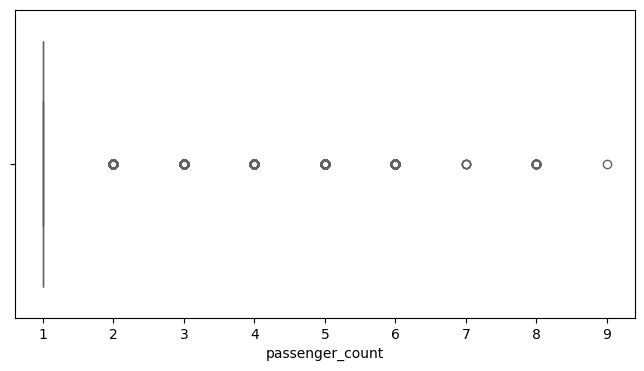

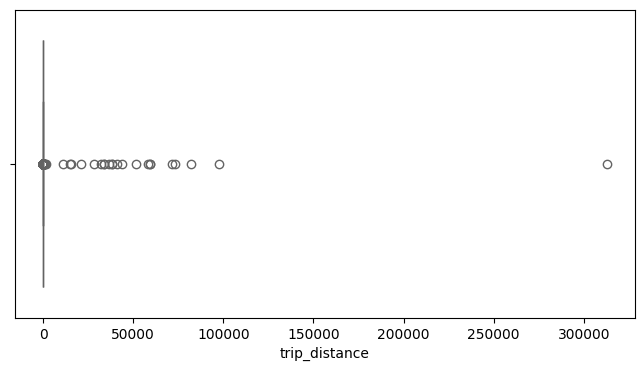

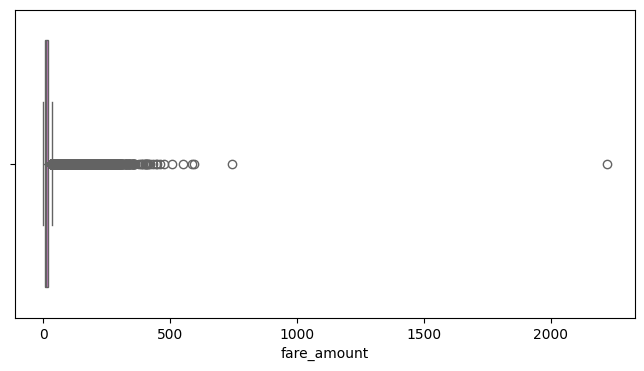

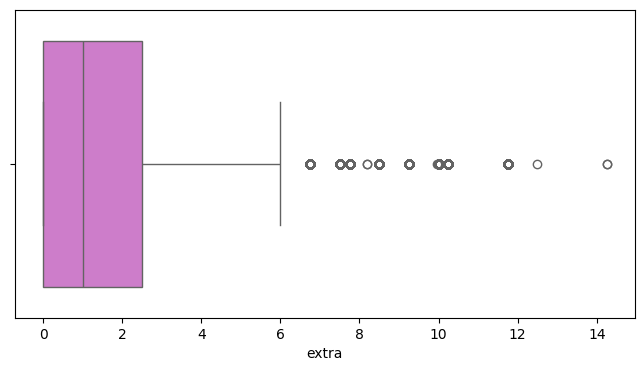

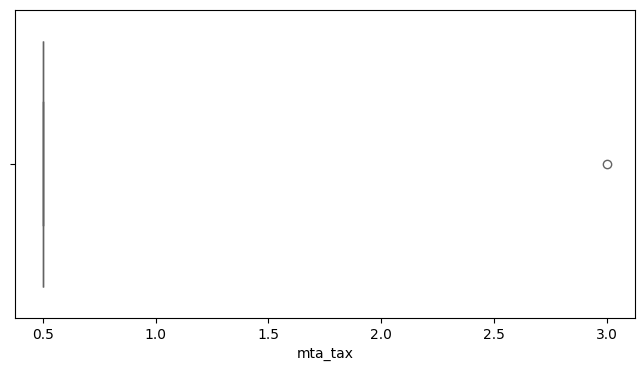

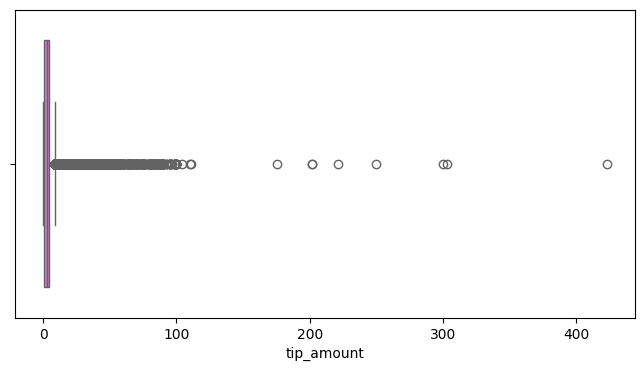

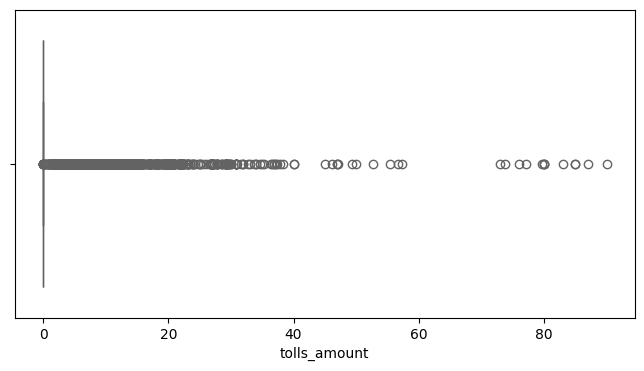

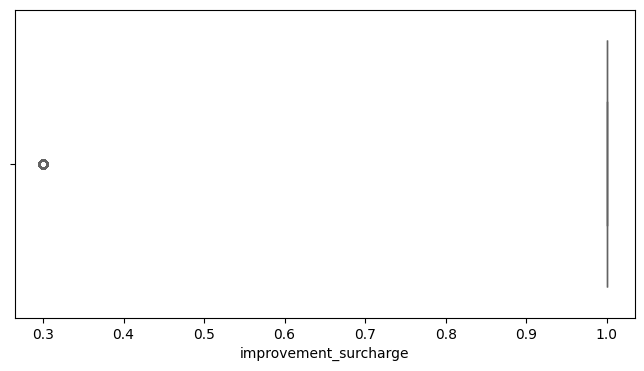

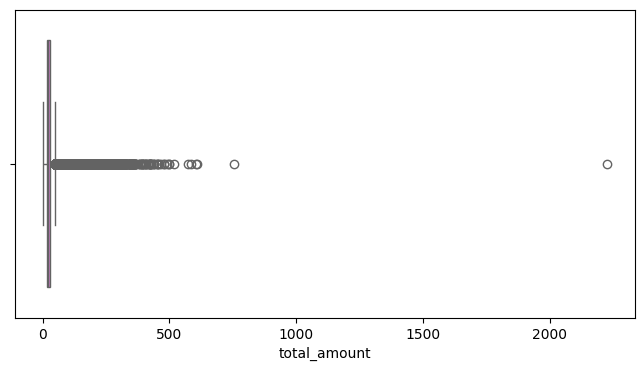

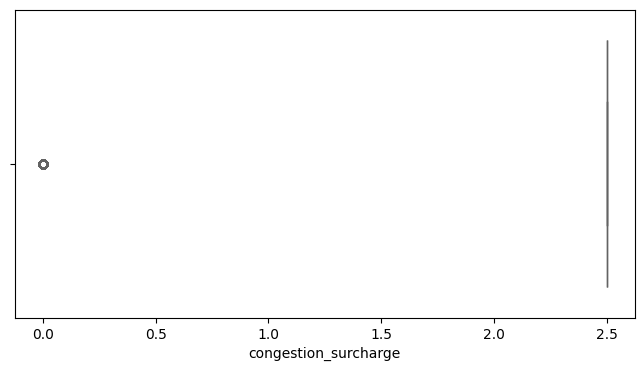

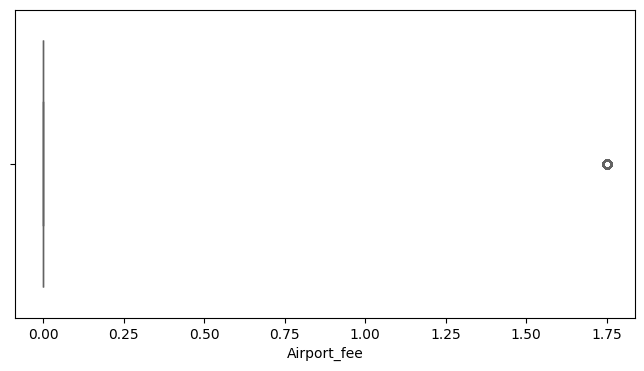

In [17]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))  # Add this to create a fresh figure
    sns.boxplot(x=trips[col], color='orchid')
    plt.show()


Most of the data shows skewness in distribution, it is better to focus on invalid data points for now. for eg., negative values, 0 is variables like passenger count or having 6+ passengers which is not possible.

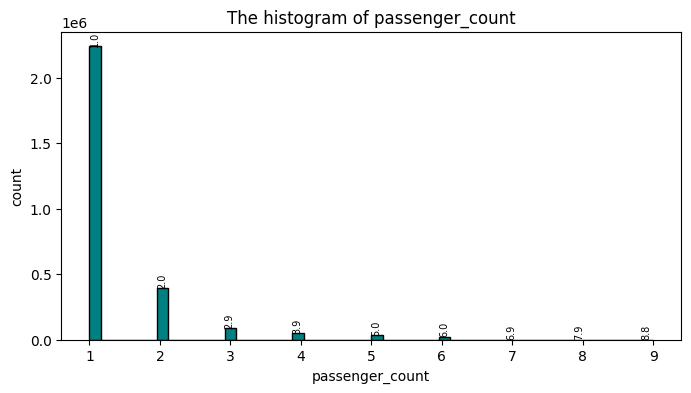

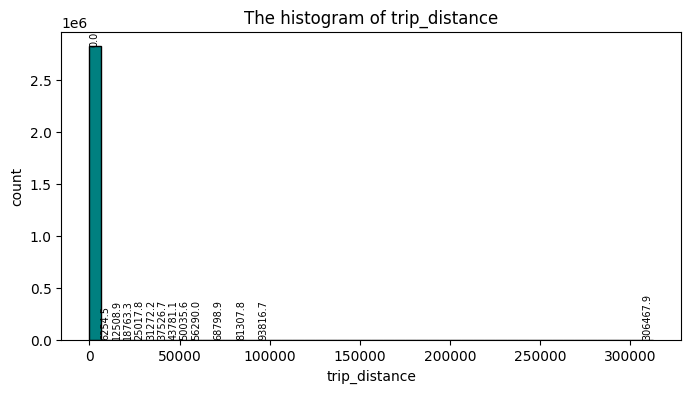

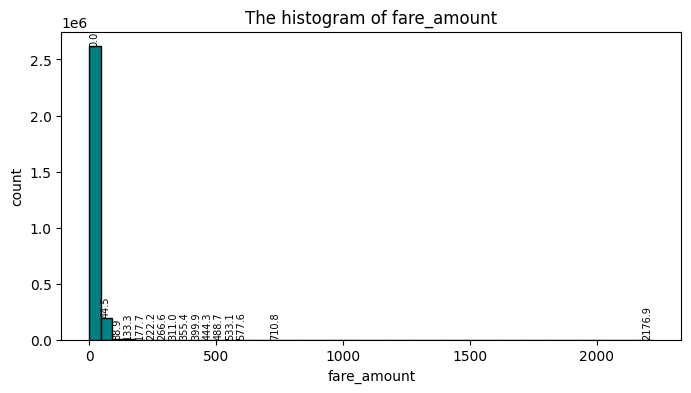

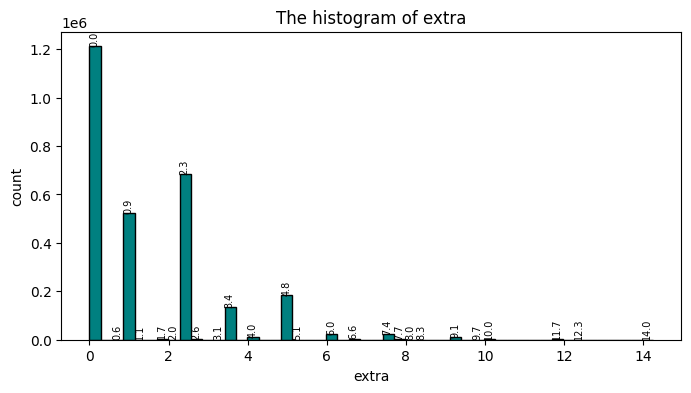

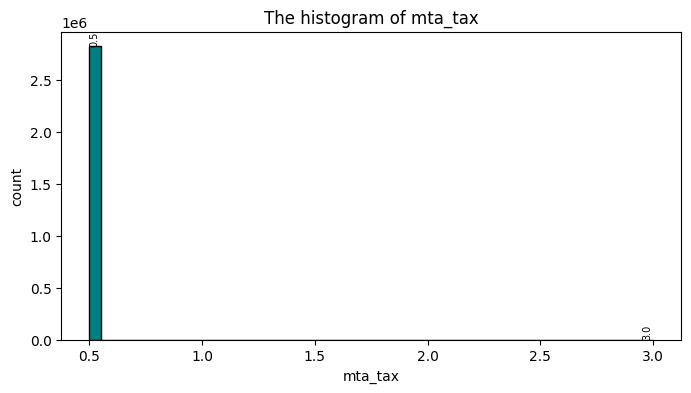

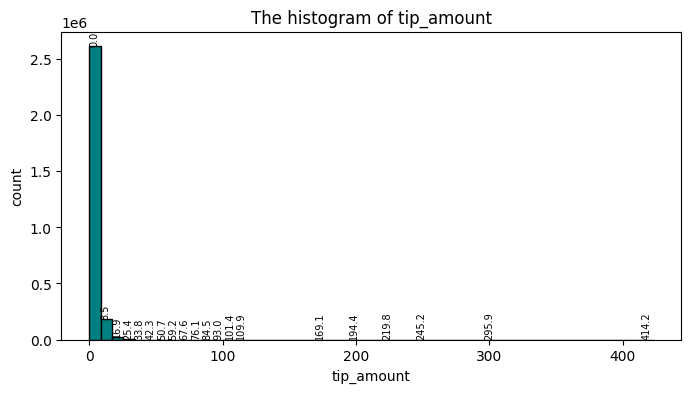

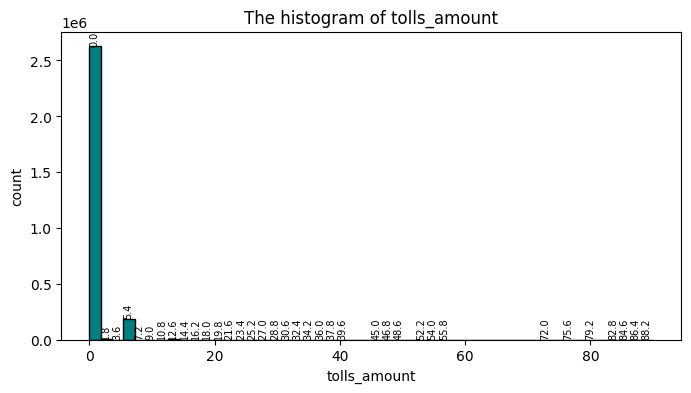

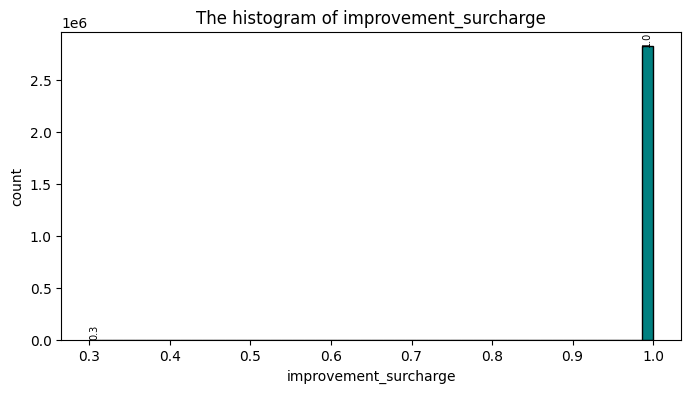

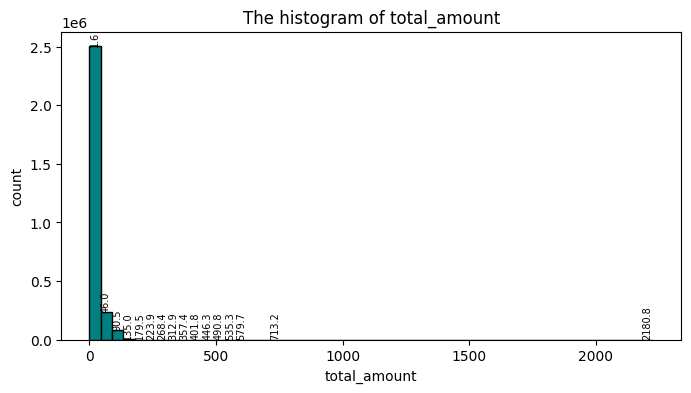

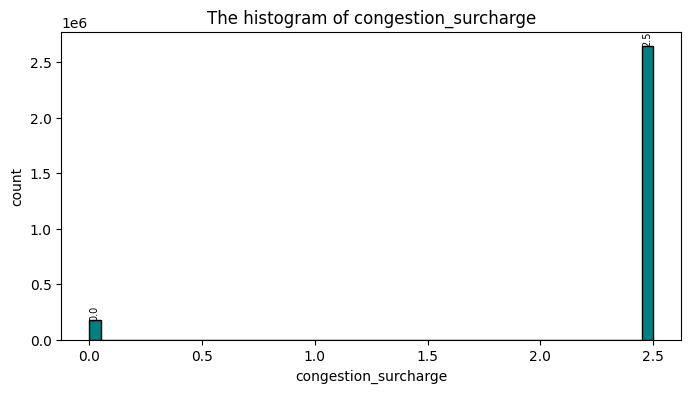

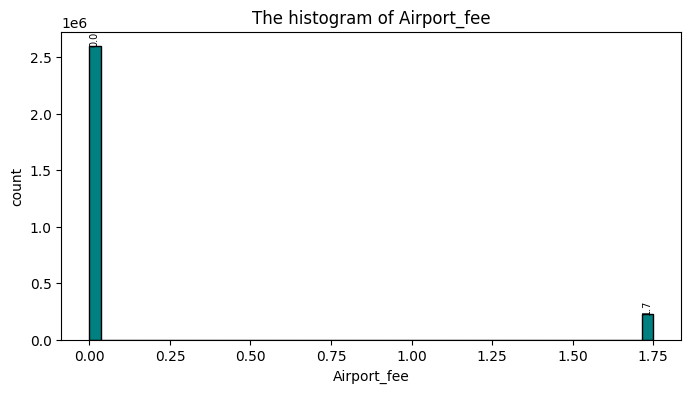

In [18]:
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    counts, bins, patches = plt.hist(trips[col].dropna(), bins=50, color='teal', edgecolor='black')
    for count, bin_left in zip(counts, bins[:-1]):
        if count > 0:
            plt.text(bin_left, count, f'{bin_left:.1f}', rotation=90, va='bottom', fontsize=7)
    plt.title(f"The histogram of {col}")
    plt.xlabel(f"{col}")
    plt.ylabel("count")

    plt.show()

In [19]:
trips.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.820625e+06,2820625,2820625,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06
mean,1.766175e+00,2024-01-17 01:25:57.819865,2024-01-17 01:41:38.524298,1.338648e+00,3.676939e+00,1.982649e+00,1.662823e+02,1.655732e+02,1.136933e+00,1.809098e+01,1.483801e+00,5.000009e-01,3.352217e+00,4.805160e-01,9.998647e-01,2.684552e+01,2.341706e+00,1.393504e-01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,1.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,3.000000e-02,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.570000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2024-01-09 16:27:21,2024-01-09 16:44:26,1.000000e+00,1.020000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.548000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-01-17 11:13:09,2024-01-17 11:31:37,1.000000e+00,1.700000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.770000e+00,0.000000e+00,1.000000e+00,2.015000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-01-24 18:38:54,2024-01-24 18:54:22,1.000000e+00,3.150000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.980000e+01,2.500000e+00,5.000000e-01,4.140000e+00,0.000000e+00,1.000000e+00,2.852000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2024-02-01 00:01:15,2024-02-01 22:04:34,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,2.221300e+03,1.425000e+01,3.000000e+00,4.227000e+02,9.000000e+01,1.000000e+00,2.225300e+03,2.500000e+00,1.750000e+00
std,4.252176e-01,NaN,NaN,8.291618e-01,2.311408e+02,9.564447e+00,6.349932e+01,6.882989e+01,5.036024e-01,1.587455e+01,1.785065e+00,1.488563e-03,3.670959e+00,1.807178e+00,9.729303e-03,2.013639e+01,6.088331e-01,4.737560e-01


In [20]:
trips['tpep_dropoff_datetime'].isnull().sum()

np.int64(0)

#### **Outlier Treatment**

In [21]:
# passenger count- remove 0 and cap till 6
trips['passenger_count'] = trips['passenger_count'].clip(upper = 6)


In [22]:
trips['trip_distance'].quantile(0.99)

np.float64(19.79)

In [23]:
# trip distance, fare amount - cap to 99th percentile

from scipy.stats.mstats import winsorize #masked stats library

cols_to_winsorize = ['trip_distance', 'tip_amount', 'tolls_amount', 'extra', 'mta_tax',
                     'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']


for col in cols_to_winsorize:
    trips[col] = winsorize(trips[col], limits = [0.01, 0.01]).data



In [24]:
trips['total_amount'] = (
    trips['fare_amount'] + trips['extra'] + trips['congestion_surcharge'] +
    trips['improvement_surcharge'] + trips['mta_tax'] +
    trips['tip_amount'] + trips['tolls_amount'] + trips['Airport_fee']
)



In [25]:
trips.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.820625e+06,2820625,2820625,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2.820625e+06,2820625.0,2.820625e+06,2.820625e+06,2820625.0,2.820625e+06,2.820625e+06,2.820625e+06
mean,1.766175e+00,2024-01-17 01:25:57.819865,2024-01-17 01:41:38.524298,1.338622e+00,3.201256e+00,1.982649e+00,1.662823e+02,1.655732e+02,1.136933e+00,1.809098e+01,1.470473e+00,0.5,3.310850e+00,4.715414e-01,1.0,2.732490e+01,2.341706e+00,1.393504e-01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,1.000000e+00,3.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,3.000000e-02,0.000000e+00,0.5,0.000000e+00,0.000000e+00,1.0,4.030000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2024-01-09 16:27:21,2024-01-09 16:44:26,1.000000e+00,1.020000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,0.5,1.000000e+00,0.000000e+00,1.0,1.600000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-01-17 11:13:09,2024-01-17 11:31:37,1.000000e+00,1.700000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,0.5,2.770000e+00,0.000000e+00,1.0,2.064000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-01-24 18:38:54,2024-01-24 18:54:22,1.000000e+00,3.150000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.980000e+01,2.500000e+00,0.5,4.140000e+00,0.000000e+00,1.0,2.900000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2024-02-01 00:01:15,2024-02-01 22:04:34,6.000000e+00,1.979000e+01,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,2.221300e+03,7.500000e+00,0.5,1.669000e+01,6.940000e+00,1.0,2.225300e+03,2.500000e+00,1.750000e+00
std,4.252176e-01,NaN,NaN,8.289853e-01,4.056767e+00,9.564447e+00,6.349932e+01,6.882989e+01,5.036024e-01,1.587455e+01,1.729477e+00,0.0,3.395346e+00,1.743412e+00,0.0,1.989797e+01,6.088331e-01,4.737560e-01


In [26]:
trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,21.25,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,33.80,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,19.50,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,18.60,2.5,0.0


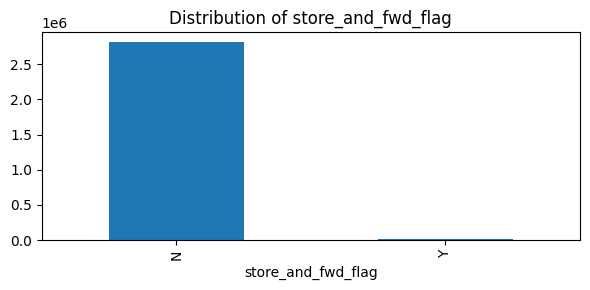

In [27]:
cat_cols = ['VendorID','RatecodeID','store_and_fwd_flag',]

for col in trips.select_dtypes(include='object').columns:
    plt.figure(figsize=(6, 3))
    trips[col].value_counts().head(10).plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


In [28]:
numeric_cols

['passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

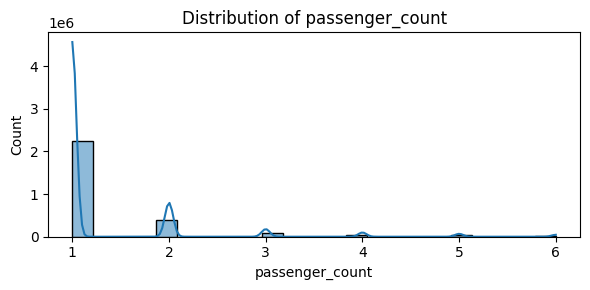

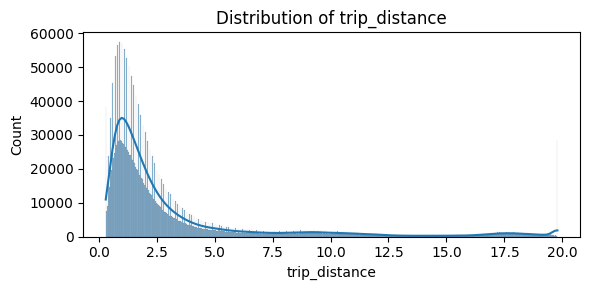

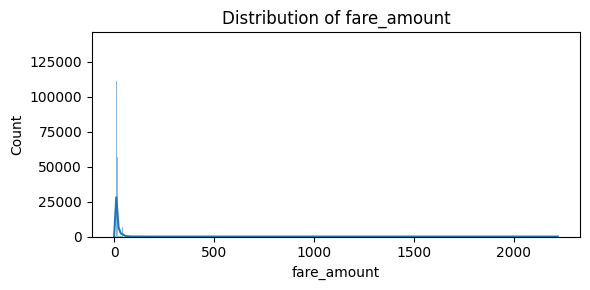

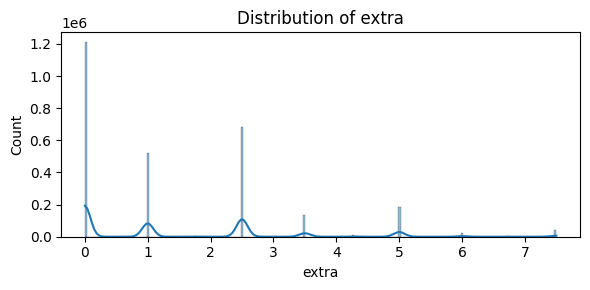

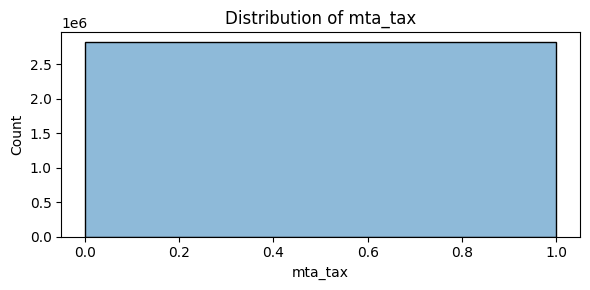

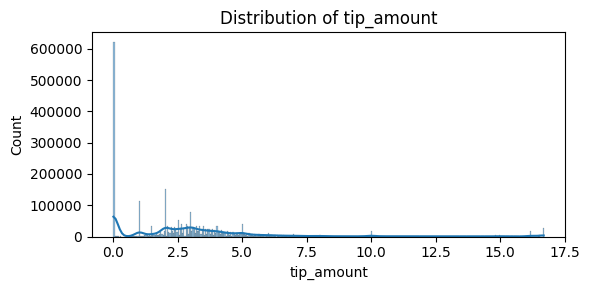

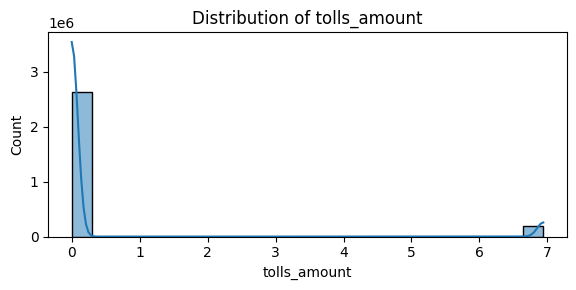

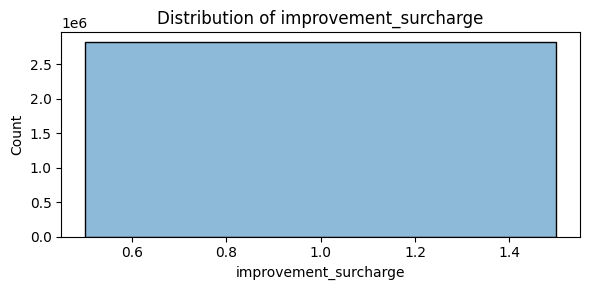

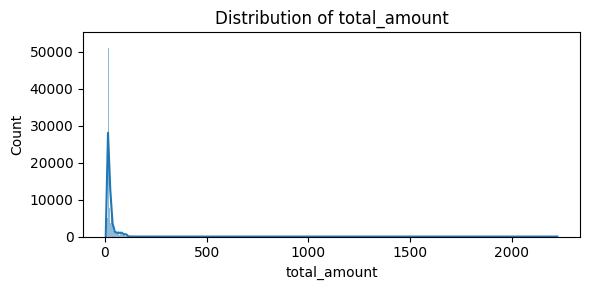

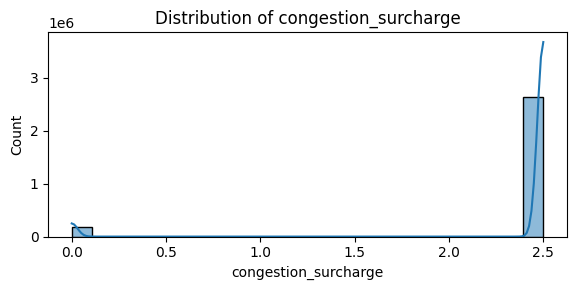

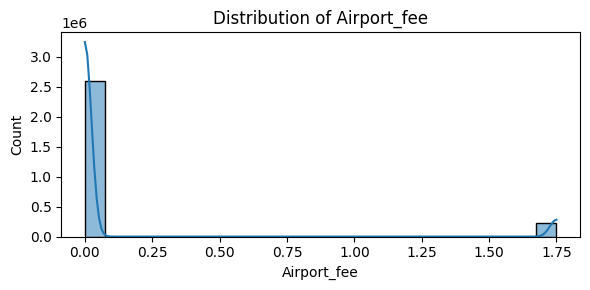

In [29]:
for col in numeric_cols:
    plt.figure(figsize = (6,3))
    sns.histplot(trips[col],kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

In [ ]:
trips.to_csv('trips_cleaned.csv',index=False)